In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.metrics import AUC, Accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy
from keras.optimizers import SGD
from matplotlib import pyplot

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
# Data Loading
print("Loading data...")
X_model = np.load('../../data/X_timeseries_expanded.npy.zip')
Y_model = pd.read_csv('../../data/Y_model.csv').values.astype(np.bool_)

Loading data...


In [4]:
# Train Test Split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X_model['X_timeseries_expanded'].astype(np.uint16), Y_model, test_size=0.2, random_state=42)

Splitting data...


KeyboardInterrupt: 

In [ ]:
# design network
# References: 
# - https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046
# - https://stats.stackexchange.com/questions/242238/what-is-considered-a-normal-quantity-of-outliers
# - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# hidden_nodes = int(2/3 * (X_train.shape[1] * X_train.shape[2]))
hidden_nodes = 256
model = Sequential()
model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(hidden_nodes, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=SGD(),
    metrics=[
        AUC(),
        Accuracy(),
    ]
)

In [ ]:
print("Training model...")
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test), 
    verbose=1,
    shuffle=False,
    callbacks=[
        EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=3,
        ),
        ModelCheckpoint(
            '../../data/lstm.h5',
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        )
    ]
)

Training model...
Epoch 1/15
10000/10000 [==============================] - 188s 19ms/step - loss: 0.2315 - auc: 0.5000 - accuracy: 0.0653 - val_loss: 0.2280 - val_auc: 0.5000 - val_accuracy: 0.0658
Epoch 2/15
10000/10000 [==============================] - 185s 19ms/step - loss: 0.2276 - auc: 0.5000 - accuracy: 0.0653 - val_loss: 0.2277 - val_auc: 0.5000 - val_accuracy: 0.0658
Epoch 3/15
10000/10000 [==============================] - 183s 18ms/step - loss: 0.2271 - auc: 0.5000 - accuracy: 0.0653 - val_loss: 0.2277 - val_auc: 0.5000 - val_accuracy: 0.0658
Epoch 4/15
10000/10000 [==============================] - 181s 18ms/step - loss: 0.2270 - auc: 0.5000 - accuracy: 0.0653 - val_loss: 0.2277 - val_auc: 0.5000 - val_accuracy: 0.0658


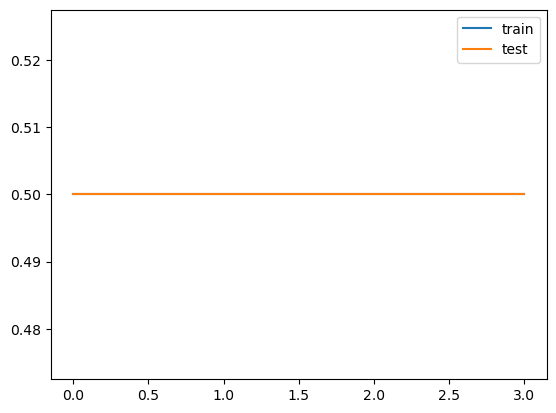

In [ ]:
# plot history
pyplot.plot(history.history['auc'], label='train')
pyplot.plot(history.history['val_auc'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Save model with pickle
import pickle
with open("../../data/model.pkl", "wb") as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://1dd19662-8a4e-42f3-ad35-b1223103a53e/assets


INFO:tensorflow:Assets written to: ram://1dd19662-8a4e-42f3-ad35-b1223103a53e/assets
